In [6]:
from google.colab import drive
drive.mount('/MyDrive')

Mounted at /MyDrive


In [11]:
!ls /MyDrive/MyDrive/ml-100k/


allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [14]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt



In [15]:
train = pd.read_csv("/MyDrive/MyDrive/ml-100k/ua.base",
                    sep="\t", names=['users', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("/MyDrive/MyDrive/ml-100k/ua.test",
                   sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

In [16]:
train


,users,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [18]:
items = torch.LongTensor(train['movie'])
user = torch.LongTensor(train['users'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [20]:
rank = 10
numItems = items.max() + 1
numUsers = user.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [50]:
optimizer = torch.optim.Adam([P, Q], lr= 0.1)
X = []
Y = []
Y_test = []
lambda1 = 0.0001
lambda2 = 0.0001
for epoch in range(1000):
    hypothesis = torch. sum(P[items] * Q[user], dim= 1)
    #mse = F.mse_loss(hypothesis, ratings)
    cost = F.mse_loss(hypothesis ,ratings)
    loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)

    optimizer.zero_grad()
    loss.backward()
    #cost.backward()
    optimizer.step()
    with torch.no_grad():
        hypo_test = (P[items_test] * Q[users_test]).sum(dim=1)
        cost_test = F.mse_loss(hypo_test, ratings_test)
        X.append(epoch)
        Y.append(cost)
        #Y.append(mse.item())
        Y_test.append(cost_test)
        #Y_test.append(mse_test)
        if epoch % 100 == 0:
            print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

epoch: 0, cost: 0.433420
epoch: 100, cost: 0.636630
epoch: 200, cost: 0.628183
epoch: 300, cost: 0.626510
epoch: 400, cost: 0.626155
epoch: 500, cost: 0.626053
epoch: 600, cost: 0.625987
epoch: 700, cost: 0.625950
epoch: 800, cost: 0.625935
epoch: 900, cost: 0.625931


In [51]:
with torch.no_grad():
    print(P[1])
    print(Q[1])
    print((P[1] * Q[1]).sum())

tensor([-0.7734,  0.2383,  1.1706,  1.4002,  0.1155, -0.4090,  0.6570, -0.0489,
        -0.5261, -0.8724], requires_grad=True)
tensor([-1.7225, -0.4043, -0.1213,  0.6497,  0.1670, -1.1774,  0.3817, -0.4055,
        -0.0510, -0.9169], requires_grad=True)
tensor(3.6018)


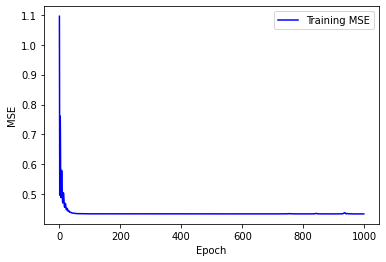

In [48]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

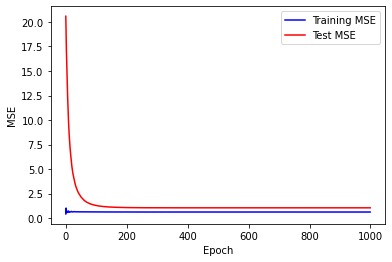

In [52]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [61]:
#bias 를 넣으면 성능이 조금 더 올라감
rank = 10
numItems = items.max() + 1
numUsers = user.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)
X = []
Y = []
Y_test = []
#0.0001,0.00001
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

for epoch in range(1000):
    hypothesis = torch. sum(P[items] * Q[user], dim= 1) + mean + bias_item[items] + bias_user[user]
    mse = F.mse_loss(hypothesis, ratings)
    #cost = F.mse_loss(hypothesis ,ratings)
    cost = mse + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)
    lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)

    optimizer.zero_grad()
    #loss.backward()
    cost.backward()
    optimizer.step()
    with torch.no_grad():
        hypo_test = (P[items_test] * Q[users_test]).sum(dim=1) +  mean + bias_item[items_test] + bias_user[users_test]
        mse_test = F.mse_loss(hypo_test, ratings_test)
        X.append(epoch)
        Y.append(cost)
        #Y.append(mse.item())
        #Y_test.append(cost_test)
        Y_test.append(mse_test)
        if epoch % 100 == 0:
            print("epoch: {}, mse: {:.6f}" .format(epoch, mse.item()))

epoch: 0, mse: 13.279936
epoch: 100, mse: 0.602079
epoch: 200, mse: 0.570506
epoch: 300, mse: 0.566205
epoch: 400, mse: 0.564656
epoch: 500, mse: 0.563946
epoch: 600, mse: 0.563683
epoch: 700, mse: 0.563581
epoch: 800, mse: 0.563517
epoch: 900, mse: 0.563458


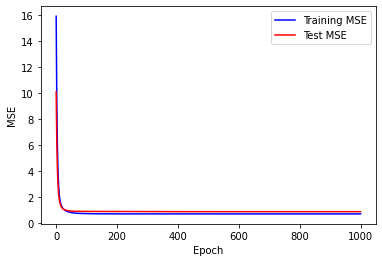

In [62]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()